In [1]:
from PIL import Image

from transformers import AutoProcessor, LlavaForConditionalGeneration
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
#torch.cuda.get_device_properties(0).total_memory

#### Load model

In [3]:
model_name = "llava-hf/llava-1.5-7b-hf"
#model_name = "llava-hf/llava-1.5-13b-hf"
#model_name = "bczhou/tiny-llava-v1-hf"
#model_name = "unsloth/llava-1.5-7b-hf-bnb-4bit"
#model_name = "liuhaotian/llava-v1.5-7b"

model =  LlavaForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)

#model = LlavaForConditionalGeneration.from_pretrained(
    #model_name, 
    #torch_dtype=torch.float16, 
    #low_cpu_mem_usage=True,
    #use_flash_attention_2=True
#).to(0)

#model = LlavaForConditionalGeneration.from_pretrained(
    #model_name,
    #torch_dtype=torch.bfloat16,
    #device_map="cpu",
#)

model.eval()

# load processor
processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

#### Image

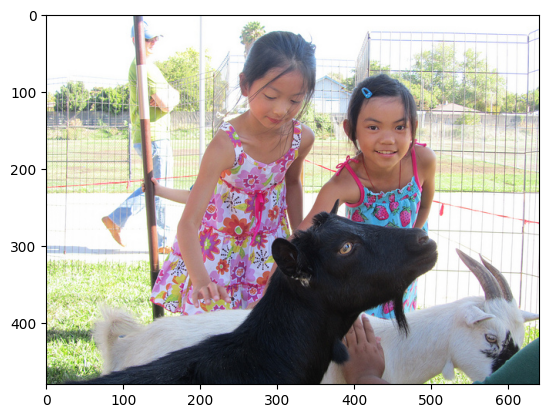

In [4]:
# TODO: image and caption from sugarcrepe

#url = "https://www.ilankelman.org/stopsigns/australia.jpg"
#image = Image.open(requests.get(url, stream=True).raw)

# sugarcrepe
image = Image.open("/home/drdo/vlm-compositionality/data/raw/coco_val_2017/000000008690.jpg")

plt.imshow(image)

#### Process image

In [5]:
prompt = "USER: <image>\nDescribe the image. ASSISTANT:"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)

In [8]:
output = model.generate(**inputs, max_new_tokens=200, do_sample=False, return_dict_in_generate=True, output_hidden_states=True)
output
#print(processor.decode(output[0][2:], skip_special_tokens=True))

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


GenerateDecoderOnlyOutput(sequences=tensor([[    1,  3148,  1001, 29901, 29871, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 

In [12]:
len(output['hidden_states'])

80

In [13]:
len(output['hidden_states'][0])

33

In [18]:
output['hidden_states'][0][5].shape

torch.Size([1, 593, 4096])

In [24]:
hidden_states = torch.stack(output.hidden_states[0])

In [22]:

from transformers.generation.logits_process import TopKLogitsWarper
from transformers.generation.logits_process import LogitsProcessorList


logits_warper = TopKLogitsWarper(top_k=50, filter_value=float("-inf"))
logits_processor = LogitsProcessorList([])


In [25]:
with torch.inference_mode():
    curr_layer_logits = model.language_model.lm_head(hidden_states).cpu().float()
    logit_scores = torch.nn.functional.log_softmax(curr_layer_logits, dim=-1)

In [26]:
logit_scores.shape

torch.Size([33, 1, 593, 32064])

In [29]:
input_ids = inputs['input_ids']

In [30]:
with torch.inference_mode():    
    logit_scores_processed = logits_processor(input_ids, logit_scores)
    logit_scores = logits_warper(input_ids, logit_scores_processed)
    softmax_probs = torch.nn.functional.softmax(logit_scores, dim=-1)

In [32]:
softmax_probs.shape

torch.Size([33, 1, 593, 32064])

In [34]:
softmax_probs = softmax_probs.detach().cpu().numpy()

In [35]:
model.config.image_token_index

32000

In [36]:
image_token_index = input_ids.tolist()[0].index(model.config.image_token_index)
softmax_probs = softmax_probs[
    :, :, image_token_index : image_token_index + (24 * 24)
]

In [38]:
scores = softmax_probs

In [41]:
def internal_confidence(tokenizer, softmax_probs, class_):
    class_token_indices = tokenizer.encode(class_)[1:]
    return softmax_probs[class_token_indices].max()


def internal_confidence_heatmap(tokenizer, softmax_probs, class_):
    class_token_indices = tokenizer.encode(class_)[1:]
    return softmax_probs[class_token_indices].max(axis=0).T


def internal_confidence_segmentation(tokenizer, softmax_probs, class_, num_patches=24):
    class_token_indices = tokenizer.encode(class_)[1:]
    return (
        softmax_probs[class_token_indices]
        .max(axis=0)
        .max(axis=0)
        .reshape(num_patches, num_patches)
        .astype(float)
    )

In [42]:
class_ = 'hair'
heatmap_data = internal_confidence_heatmap(processor.tokenizer, softmax_probs, class_)
num_image_embeddings = softmax_probs.shape[2]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{class_}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 1)
plt.colorbar()
plt.show()

IndexError: index 11315 is out of bounds for axis 0 with size 33

#### Forward pass

In [7]:
# 32+1 layers
# each layer hidden_state -> b x seq_len x embed_dim [ignoring b = 1]

# model.vision_tower = CLIPVisionModel
# model.config.vision_feature_layer = -2

# pixel_values : torch.Size([1, 3, 336, 336])
# patch_embeds: torch.Size([1, 1024, 24, 24])
# patch_embeds flattened : torch.Size([1, 576, 1024])
# embeddings : torch.Size([1, 577, 1024])
# hidden_states : torch.Size([1, 577, 1024])
# hidden_states output -2 layer : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 576, 1024])
# image_features : torch.Size([1, 576, 4096])

In [8]:
output = model(**inputs, output_hidden_states=True)

In [9]:
model.language_model.model.norm

LlamaRMSNorm((4096,), eps=1e-05)

#### Get softmax scores for layer

In [10]:
image_indices = torch.nonzero((inputs['input_ids'][0] == model.config.image_token_index).long())
image_indices = image_indices.flatten()
reps = torch.vstack(output['hidden_states'])    # 33, 593, 4096

image_reps = torch.index_select(reps, 1, image_indices)    # 33, 576, 4096
#image_reps = torch.rand(33, 576, 4096).to(torch.bfloat16)

In [13]:
# TODO: exclude hidden state from last decoder layer (already done in model)
model.language_model.model.norm(image_reps).shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 298.00 MiB. GPU 0 has a total capacity of 23.61 GiB of which 317.50 MiB is free. Including non-PyTorch memory, this process has 19.23 GiB memory in use. Of the allocated memory 18.37 GiB is allocated by PyTorch, and 415.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
unembed_matrix = model.language_model.lm_head
unembedded_image_reps = unembed_matrix(image_reps)    # 33, 576, 32064

In [7]:
# scores for all layers
scores = F.softmax(unembedded_image_reps, dim=2)
scores.shape

torch.Size([41, 576, 32064])

#### Get max tokens

In [30]:
max_tokens = torch.argmax(scores, dim=2)    # 33, 576
#processor.tokenizer.batch_decode(max_tokens)

#### Map embeddings to image patches

In [ ]:
# How to map patch_embeds to pixel_values?

In [39]:
def internal_confidence_heatmap(tokenizer, scores, object):
    class_token_indices = tokenizer.encode(object)[1:]
    if len(class_token_indices) > 1:
        heatmap = 0
        for index in class_token_indices:
            heatmap += scores[:, :, index]
        # TODO: average
        return heatmap.T
    else:
        return torch.squeeze(scores[:, :, class_token_indices], dim=2).T

In [40]:
#object = 'tree'
#object = 'car'
#object = 'signs'
#object = 'red'
#object = 'stop'
#object = 'gate'
#object = 'leaves'

# 000000002592.jpg
#object = 'knife'
#object = 'mug'

# 000000008690.jpg
#object = 'goat'
#object = 'girl'
object = 'hair'
#object = 'tree'

heatmap_data = internal_confidence_heatmap(processor.tokenizer, scores, object).detach().cpu().float()
num_image_embeddings = scores.shape[1]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{object}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 1)   # 0, 1
plt.colorbar()
plt.show()

IndexError: index 11315 is out of bounds for axis 2 with size 576

In [19]:
def internal_confidence_segmentation(tokenizer, scores, object, num_patches=24):
    class_token_indices = tokenizer.encode(object)[1:]

    if len(class_token_indices) > 1:
        obj_scores = 0
        for index in class_token_indices:
            obj_scores += scores[:, :, index]  
    else:
        obj_scores = torch.squeeze(scores[:, :, class_token_indices], dim = 2)
    max_obj_scores = torch.max(obj_scores, dim=0).values.reshape(num_patches, num_patches).float()
    return max_obj_scores

/tmp/ipykernel_1683/777978903.py:4: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  segmentation_resized = (np.array(Image.fromarray(segmentation.detach().cpu().numpy()).resize((img_width, img_height), Image.BILINEAR)))


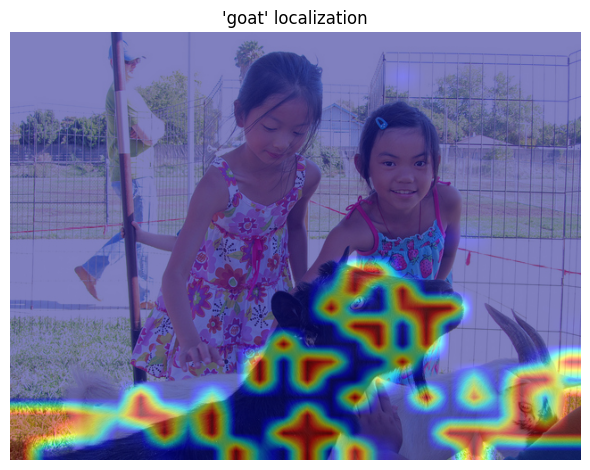

In [20]:
img_width, img_height = image.size

segmentation = internal_confidence_segmentation(processor.tokenizer, scores, object, num_patches=24)
segmentation_resized = (np.array(Image.fromarray(segmentation.detach().cpu().numpy()).resize((img_width, img_height), Image.BILINEAR)))

plt.imshow(image)
plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=0.5)
plt.axis('off')
plt.title(f"'{object}' localization")
plt.tight_layout()
plt.show()

In [1]:
from ultralytics import YOLO
import random
import cv2
import numpy as np

In [2]:
img = cv2.imread("/home/drdo/Downloads/bus.jpg")

model = YOLO("yolo11n-seg.pt")  # load an official model
results = model("/home/drdo/Downloads/bus.jpg") 


image 1/1 /home/drdo/Downloads/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 34.6ms
Speed: 2.1ms preprocess, 34.6ms inference, 55.2ms postprocess per image at shape (1, 3, 640, 480)


In [4]:
yolo_classes = list(model.names.values())
classes_ids = [yolo_classes.index(clas) for clas in yolo_classes]

colors = [random.choices(range(256), k=3) for _ in classes_ids]
print(results)
for result in results:
    for mask, box in zip(result.masks.xy, result.boxes):
        points = np.int32([mask])
        # cv2.polylines(img, points, True, (255, 0, 0), 1)
        color_number = classes_ids.index(int(box.cls[0]))
        cv2.fillPoly(img, points, colors[color_number])

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chai

In [5]:
cv2.imshow("Image", img)